# ECE 763 Project 01: Face Detection
## faceScrub dataset

In [1]:
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image
from tqdm import tqdm

## Global Methods and Variables

In [2]:
# Image size in pixels
img_size = (20,20)

# Create dataset dictionaries
def buildDataset(actors_list):
  img_set = [] # empty list
  for actor in tqdm(actors_list, total=len(actors_list) ,desc='Loading dataset'):
    img0 = {} # empty dictionary
    img1 = {} # empty dictionary
    try:
      # create dictionary and add it to the list
      img0['file'] = actor['0']
      img0['class'] = 0
      img0['image'] = Image.open(actor['0'])
      img_set.append(img0)
      img1['file'] = actor['1']
      img1['class'] = 1
      img1['image'] = Image.open(actor['1'])
      img_set.append(img1)
    except:
      print(actor['name'] + " couldn't be found!")
  return img_set


# Perform whitening to data
def whitening(data):
    eps = 0.0001 # Constant to avoid overflow in division
    mean = sum(data) / len(data)
    std = np.sqrt( sum(np.power( data - mean, 2) ) / len(data) )
    white = (data - mean) / (std + eps)
    return white, mean, std


# Perform dewhitening (Inverse of whitening)
def deWhitening(data, mean, std):
    eps = 0.0001
    inv_white = data * (std+eps) + mean
    return inv_white


# Reshape vector to RGB image
def convertToImage(X, model, mean, std, cov=False):
  img = model.inverse_transform(X)
  img = np.reshape(img, [img_size[0],img_size[1],3])
  img = deWhitening(img, mean, std)
  if cov: # is a covariance vector?
    img = np.sqrt( abs(img) )
  return img.astype(np.uint8)



Load datasets into memmory

In [3]:
test_actors = []
train_actors = []

test_file = './data/test/test.txt'
train_file = './data/training/training.txt'

# Read test data
with open(test_file, newline='') as actors:
    actors_reader = csv.DictReader(actors, delimiter='\t')
    for actor in actors_reader:
        test_actors.append(actor)

# Read training data
with open(train_file, newline='') as actors:
    actors_reader = csv.DictReader(actors, delimiter='\t')
    for actor in actors_reader:
        train_actors.append(actor)

# Build datasets
test_set = buildDataset(test_actors)
train_set = buildDataset(train_actors)

Loading dataset: 100%|██████████| 1000/1000 [00:00<00:00, 10889.43it/s]


Apply whitening and PCA transformations to all dataset (test set + train set)

In [4]:
# Retreive faces and non-faces images from all dataset
faces_list = [ np.asfarray(face['image']) for face in test_set+train_set if face['class']==1 ]
nonfaces_list = [ np.asfarray(face['image']) for face in test_set+train_set if face['class']==0 ]

# Apply data whitening transformation
faces_white, face_avg, face_std = whitening(faces_list)
nonfaces_white, nonface_avg, nonface_std = whitening(nonfaces_list)

# Apply PCA transformation
n_cmpts = 10

face_model = PCA(n_components=n_cmpts)
faces_PCA = face_model.fit_transform( np.stack(faces_white).reshape( (len(faces_white), faces_white[0].size) ) ) 

nonface_model = PCA(n_components=n_cmpts)
nonfaces_PCA = nonface_model.fit_transform( np.stack(nonfaces_white).reshape( (len(nonfaces_white), nonfaces_white[0].size) ) )

# Inspect data
print('Face whitening')
print('faces_white:' + str(faces_white.shape) + '  face_avg:' + str(face_avg.shape) + '  face_std:' + str(face_std.shape))
print('Non-face whitening')
print('nonfaces_white:' + str(nonfaces_white.shape) + '  nonface_avg:' + str(nonface_avg.shape) + '  nonface_std:' + str(nonface_std.shape))
print('Face PCA')
print('faces_PCA:' + str(faces_PCA.shape))
print('Non-face PCA')
print('nonfaces_PCA:' + str(nonfaces_PCA.shape))

Face whitening
faces_white:(1100, 20, 20, 3)  face_avg:(20, 20, 3)  face_std:(20, 20, 3)
Non-face whitening
nonfaces_white:(1100, 20, 20, 3)  nonface_avg:(20, 20, 3)  nonface_std:(20, 20, 3)
Face PCA
faces_PCA:(1100, 10)
Non-face PCA
nonfaces_PCA:(1100, 10)


Split pre-process data to create face and non face data matrixes for the test and train set respectively

In [5]:
# Retreive pre-processed test and training datasets
face_test_size = len([face for face in test_set if face['class']==1])
nonface_test_size = len([face for face in test_set if face['class']==0])

X1_test = faces_PCA[:face_test_size,:]
X1_train = faces_PCA[face_test_size-1:-1,:]

X0_test = nonfaces_PCA[:nonface_test_size,:]
X0_train = nonfaces_PCA[nonface_test_size-1:-1,:]

# Inspect data
print('Face data')
print('X1_train:' + str(X1_train.shape) + '  X1_test:' + str(X1_test.shape))
print('Non-face data')
print('X0_train:' + str(X0_train.shape) + '  X0_test:' + str(X0_test.shape))

Face data
X1_train:(1000, 10)  X1_test:(100, 10)
Non-face data
X0_train:(1000, 10)  X0_test:(100, 10)


# Single Multivariate Gaussian Model

## Methods SMG Model

In [6]:
def logProbSMG(X, mu, sigma):
    dim = len(mu.ravel())
    log_2pi = -dim / 2*np.log(2*math.pi)
    log_sigma = -1/2 * np.sum(np.log(sigma), where=(sigma>0))
    log_mu = -1/2 * np.sum( np.power(X-mu,2) / sigma, axis=1)
    log_prob = log_2pi + log_sigma + log_mu
    return log_prob


def fitSMG(X):
    num_data = X.shape[0]
    mu = np.sum(X,axis=0) / num_data
    sigma = np.zeros( [1, X[0].size] )
    for i in range(num_data):
        x = X[i]
        sigma += np.power(x-mu,2)
    sigma = sigma / num_data
    return mu, sigma


def predictSMG(X, label, mean, sigma, threshold):
    num_data = X.shape[0]
    num_class = len(mean)
    log_prob = np.zeros([num_class,num_data])
    for i in range(num_class):
        log_prob[i,:] = logProbSMG(X, mean[i], sigma[i])  
    prob = np.exp(log_prob)    
    norm_prob = prob[1,:] / (prob[1,:] + prob[0,:])
    num_true = sum( ( norm_prob>=threshold ) == label )
    num_false = num_data - num_true
    return num_true, num_false

Compute sample mean vector and sample covariance matrix and visualize the estimated mean and covariance matrix for face and non-face respectively

Text(0.5, 1.0, '$\\Sigma_1^{diag}$')

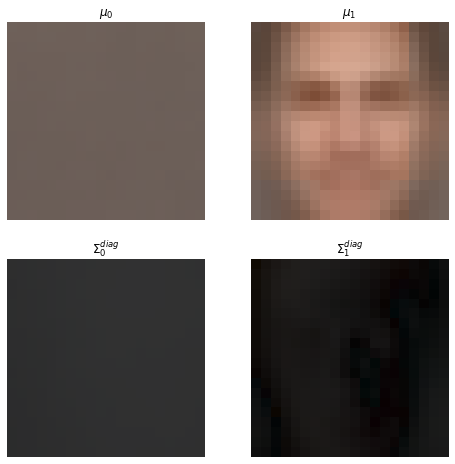

In [7]:
# Emtpy lists
mu_SMG = [None,None] # Mean
sigma_SMG = [None,None] # Covariance 

# Train model
mu_SMG[0] ,sigma_SMG[0] = fitSMG(X0_train)
mu_SMG[1] ,sigma_SMG[1] = fitSMG(X1_train)

# Convert vectors to images
mu0_SMG_image = convertToImage(mu_SMG[0], nonface_model, nonface_avg, nonface_std)
mu1_SMG_image = convertToImage(mu_SMG[1], face_model, face_avg, face_std)

sigma0_SMG_image = convertToImage(sigma_SMG[0], nonface_model, nonface_avg, nonface_std, cov=True)
sigma1_SMG_image = convertToImage(sigma_SMG[1], face_model, face_avg, face_std, cov=True)

# Plot code
fig, axes = plt.subplots(2,2, figsize=(8,8))
[axi.axis('off') for axi in axes.flat] # hide axis

axes[0,1].imshow(mu1_SMG_image)
axes[0,1].set_title(r'$\mu_1$')
axes[0,0].imshow(mu0_SMG_image)
axes[0,0].set_title(r'$\mu_0$')
axes[1,0].imshow(sigma0_SMG_image)
axes[1,0].set_title(r'$\Sigma_0^{diag}$')
axes[1,1].imshow(sigma1_SMG_image)
axes[1,1].set_title(r'$\Sigma_1^{diag}$')



Evaluate the learned model on the testing images using 0.5 as threshold for the posterior. Compute False Positive Rate (FPR), False Negative Rate (FNR) and the missclasification rate (MR).

In [8]:
threshold = 0.5 # detection threshold

TP, FN = predictSMG( X1_test, np.ones(X1_test.shape[0]), mu_SMG, sigma_SMG, threshold)
TN, FP = predictSMG( X0_test, np.zeros(X0_test.shape[0]), mu_SMG, sigma_SMG, threshold)

# Compute rates
FPR = FP / (FP+TN)
FNR = FN / (TP+FN)
MR = (FP + FN) / (X0_test.shape[0] + X1_test.shape[0])

# Print results
print("False Positive Rate   : ",round(FPR,3))
print("False Negative Rate   : ",round(FNR,3))
print("Misclassification Rate: ",round(MR,3))

False Positive Rate   :  0.16
False Negative Rate   :  0.17
Misclassification Rate:  0.165


ROC curve

Text(0.5, 1.0, 'ROC Curve Simple Gaussian Model')

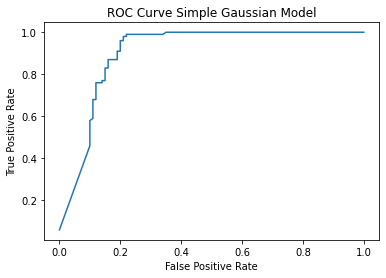

In [9]:
plt.figure()
steps = 1000
plt_FPR = np.zeros(steps)
plt_TPR = np.zeros(steps)
for i in range(0,steps):
    threshold = i/(steps-1)
    TP, FN = predictSMG( X1_test, np.ones(X1_test.shape[0]), mu_SMG, sigma_SMG, threshold)
    TN, FP = predictSMG( X0_test, np.zeros(X0_test.shape[0]), mu_SMG, sigma_SMG, threshold)
    plt_FPR[i] = FP / (FP+TN) 
    plt_TPR[i] = 1 - FN / (FN+TP)
plt.plot(plt_FPR,plt_TPR)
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate") 
plt.title("ROC Curve Simple Gaussian Model")